In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import sys
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import os
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

# Part 1 - Data Preprocessing 

In [2]:
class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """

    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):

        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(os.path.join(base_path, "gt_image"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id) / float(self.batch_size)))

    def __load__(self, id_name):
        image_path = os.path.join(self.base_path, "gt_image", (id_name ))
        label_path = os.path.join(self.base_path, "gt_binary_image", (id_name ))
        #print(image_path)
        image = cv2.imread(image_path, 1)  # Reading Image in RGB format
        image = cv2.resize(image, (self.img_size, self.img_size))
        # image = cv2.resize(image, (int(img.shape[1]/2), int(img.shape[0]/2)))
        #print(label_path)
        mask = cv2.imread(label_path, 1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        # mask = cv2.resize(mask, (int(img.shape[1]/2), int(img.shape[0]/2)))

        # Normalizing the image
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.id):
            file_batch = self.id[index * self.batch_size:]
        else:
            file_batch = self.id[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for id_name in file_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)




# Part 2 - Model

In [3]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)
    
    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)
    
    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

def Resunetpp(sz = (256, 256, 3)):
    x = Input(sz)
    n_filters = [16, 32, 64, 128, 256]
    c0 = x
    c1 = stem_block(c0, n_filters[0], strides=1)

    ## Encoder
    c2 = resnet_block(c1, n_filters[1], strides=2)
    c3 = resnet_block(c2, n_filters[2], strides=2)
    c4 = resnet_block(c3, n_filters[3], strides=2)

    ## Bridge
    b1 = aspp_block(c4, n_filters[4])

    ## Decoder
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, n_filters[3])

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, n_filters[2])

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, n_filters[1])

    ## output
    outputs = aspp_block(d3, n_filters[0])
    outputs = Conv2D(1, (1, 1), padding="same")(outputs)
    outputs = Activation("sigmoid")(outputs)

    ## Model
    model = Model(x, outputs)
    return model

# Evaluation Metrics

In [4]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        
        return iou

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)



def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
    

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# COMPILING MODEL

In [5]:

model = Resunetpp()

checkpoint = ModelCheckpoint(r"C:\TUsimple_ResUNet++\model", verbose=1, monitor ='val_loss',  save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
callbacks = [ checkpoint, reduce_lr]

opt = tf.keras.optimizers.experimental.Adam(1e-3)
metrics = [f1, iou , dice_coef ]

model.compile(loss=dice_coef_loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

train_generator = DataGenerator2D(r"E:\NU\TUsimple\train_set\training", img_size=256, batch_size=10, shuffle=True)
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256, batch_size=10, shuffle=False)

# Part 3 - Training

history = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=20,
                              validation_steps=10,
                              epochs=100,
                              callbacks=callbacks)

print(history.history.keys())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

 activation_3 (Activation)      (None, 128, 128, 32  0           ['batch_normalization_5[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 64)   18496       ['activation_3[0][0]']           
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_8 

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_4 (Add)                    (None, 32, 32, 256)  0           ['batch_normalization_11[0][0]', 
                                                                  'batch_normalization_12[0][0]', 
                                                                  'batch_normalization_13[0][0]', 
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 batch_nor

                                                                                                  
 activation_12 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_21[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 64, 64, 128)  512        ['multiply_5[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 12  36992       ['activation_12[0][0]']          
                                8)                                                                
                                                                                                  
 activatio

                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  9280        ['activation_17[0][0]']          
                                )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_28[0][0]'] 
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64  0          ['conv2d_29[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_30

 conv2d_38 (Conv2D)             (None, 256, 256, 16  4624        ['multiply_9[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 256, 256, 16  64         ['conv2d_35[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 256, 256, 16  64         ['conv2d_36[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 256, 256, 16  64         ['conv2d_37[0][0]']              
 ormalizat

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 57s 1s/step - loss: 0.7086 - f1: 0.3045 - iou: 0.1717 - dice_coef: 0.2871 - val_loss: 0.9159 - val_f1: 0.0000e+00 - val_iou: 0.0439 - val_dice_coef: 0.0841 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.5086 - f1: 0.5192 - iou: 0.3311 - dice_coef: 0.4914
Epoch 2: val_loss did not improve from 0.91590
20/20 [==============================] - 12s 598ms/step - loss: 0.5086 - f1: 0.5192 - iou: 0.3311 - dice_coef: 0.4914 - val_loss: 0.9503 - val_f1: 0.0000e+00 - val_iou: 0.0256 - val_dice_coef: 0.0497 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.3962 - f1: 0.6192 - iou: 0.4392 - dice_coef: 0.6038
Epoch 3: val_loss did not improve from 0.91590
20/20 [==============================] - 13s 627ms/step - loss: 0.3962 - f1: 0.6192 - iou: 0.4392 - dice_coef: 0.6038 - val_loss: 0.9888 - val_f1: 0.0000e+00 - val_iou: 0.0058 - val_dice_coef: 0.0112 - lr: 0.0010
Epoch 4/100
20/20 [=====

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 24s 1s/step - loss: 0.1219 - f1: 0.8797 - iou: 0.8045 - dice_coef: 0.8781 - val_loss: 0.9057 - val_f1: 0.0881 - val_iou: 0.0521 - val_dice_coef: 0.0943 - lr: 6.2500e-05
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 0.1112 - f1: 0.8918 - iou: 0.8256 - dice_coef: 0.8888
Epoch 17: val_loss improved from 0.90574 to 0.85812, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 24s 1s/step - loss: 0.1112 - f1: 0.8918 - iou: 0.8256 - dice_coef: 0.8888 - val_loss: 0.8581 - val_f1: 0.1367 - val_iou: 0.0804 - val_dice_coef: 0.1419 - lr: 6.2500e-05
Epoch 18/100
20/20 [==============================] - ETA: 0s - loss: 0.1148 - f1: 0.8879 - iou: 0.8291 - dice_coef: 0.8852
Epoch 18: val_loss improved from 0.85812 to 0.77612, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 24s 1s/step - loss: 0.1148 - f1: 0.8879 - iou: 0.8291 - dice_coef: 0.8852 - val_loss: 0.7761 - val_f1: 0.2195 - val_iou: 0.1326 - val_dice_coef: 0.2239 - lr: 6.2500e-05
Epoch 19/100
20/20 [==============================] - ETA: 0s - loss: 0.1225 - f1: 0.8774 - iou: 0.8110 - dice_coef: 0.8775
Epoch 19: val_loss improved from 0.77612 to 0.69161, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 24s 1s/step - loss: 0.1225 - f1: 0.8774 - iou: 0.8110 - dice_coef: 0.8775 - val_loss: 0.6916 - val_f1: 0.3038 - val_iou: 0.1927 - val_dice_coef: 0.3084 - lr: 6.2500e-05
Epoch 20/100
20/20 [==============================] - ETA: 0s - loss: 0.0920 - f1: 0.9088 - iou: 0.8558 - dice_coef: 0.9080
Epoch 20: val_loss improved from 0.69161 to 0.64507, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 24s 1s/step - loss: 0.0920 - f1: 0.9088 - iou: 0.8558 - dice_coef: 0.9080 - val_loss: 0.6451 - val_f1: 0.3524 - val_iou: 0.2275 - val_dice_coef: 0.3549 - lr: 6.2500e-05
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.1068 - f1: 0.8934 - iou: 0.8357 - dice_coef: 0.8932
Epoch 21: val_loss improved from 0.64507 to 0.58959, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.1068 - f1: 0.8934 - iou: 0.8357 - dice_coef: 0.8932 - val_loss: 0.5896 - val_f1: 0.4089 - val_iou: 0.2712 - val_dice_coef: 0.4104 - lr: 6.2500e-05
Epoch 22/100
20/20 [==============================] - ETA: 0s - loss: 0.1168 - f1: 0.8852 - iou: 0.8173 - dice_coef: 0.8832
Epoch 22: val_loss improved from 0.58959 to 0.53216, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 27s 1s/step - loss: 0.1168 - f1: 0.8852 - iou: 0.8173 - dice_coef: 0.8832 - val_loss: 0.5322 - val_f1: 0.4669 - val_iou: 0.3202 - val_dice_coef: 0.4678 - lr: 6.2500e-05
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.0766 - f1: 0.9236 - iou: 0.8845 - dice_coef: 0.9234
Epoch 23: val_loss improved from 0.53216 to 0.46216, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0766 - f1: 0.9236 - iou: 0.8845 - dice_coef: 0.9234 - val_loss: 0.4622 - val_f1: 0.5372 - val_iou: 0.3839 - val_dice_coef: 0.5378 - lr: 6.2500e-05
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.0953 - f1: 0.9053 - iou: 0.8547 - dice_coef: 0.9047
Epoch 24: val_loss improved from 0.46216 to 0.42011, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0953 - f1: 0.9053 - iou: 0.8547 - dice_coef: 0.9047 - val_loss: 0.4201 - val_f1: 0.5824 - val_iou: 0.4260 - val_dice_coef: 0.5799 - lr: 6.2500e-05
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 0.0888 - f1: 0.9112 - iou: 0.8675 - dice_coef: 0.9112
Epoch 25: val_loss improved from 0.42011 to 0.38079, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0888 - f1: 0.9112 - iou: 0.8675 - dice_coef: 0.9112 - val_loss: 0.3808 - val_f1: 0.6212 - val_iou: 0.4643 - val_dice_coef: 0.6192 - lr: 6.2500e-05
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.0992 - f1: 0.9008 - iou: 0.8448 - dice_coef: 0.9008
Epoch 26: val_loss improved from 0.38079 to 0.27985, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 27s 1s/step - loss: 0.0992 - f1: 0.9008 - iou: 0.8448 - dice_coef: 0.9008 - val_loss: 0.2798 - val_f1: 0.7242 - val_iou: 0.5797 - val_dice_coef: 0.7202 - lr: 6.2500e-05
Epoch 27/100
20/20 [==============================] - ETA: 0s - loss: 0.0774 - f1: 0.9233 - iou: 0.8823 - dice_coef: 0.9226
Epoch 27: val_loss did not improve from 0.27985
20/20 [==============================] - 12s 610ms/step - loss: 0.0774 - f1: 0.9233 - iou: 0.8823 - dice_coef: 0.9226 - val_loss: 0.3062 - val_f1: 0.6963 - val_iou: 0.5459 - val_dice_coef: 0.6938 - lr: 6.2500e-05
Epoch 28/100
20/20 [==============================] - ETA: 0s - loss: 0.0923 - f1: 0.9070 - iou: 0.8530 - dice_coef: 0.9077
Epoch 28: val_loss improved from 0.27985 to 0.22877, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0923 - f1: 0.9070 - iou: 0.8530 - dice_coef: 0.9077 - val_loss: 0.2288 - val_f1: 0.7747 - val_iou: 0.6456 - val_dice_coef: 0.7712 - lr: 6.2500e-05
Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 0.1012 - f1: 0.8990 - iou: 0.8440 - dice_coef: 0.8988
Epoch 29: val_loss improved from 0.22877 to 0.19748, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.1012 - f1: 0.8990 - iou: 0.8440 - dice_coef: 0.8988 - val_loss: 0.1975 - val_f1: 0.8067 - val_iou: 0.6900 - val_dice_coef: 0.8025 - lr: 6.2500e-05
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.0628 - f1: 0.9365 - iou: 0.9099 - dice_coef: 0.9372
Epoch 30: val_loss did not improve from 0.19748
20/20 [==============================] - 13s 601ms/step - loss: 0.0628 - f1: 0.9365 - iou: 0.9099 - dice_coef: 0.9372 - val_loss: 0.1977 - val_f1: 0.8059 - val_iou: 0.6915 - val_dice_coef: 0.8023 - lr: 6.2500e-05
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 0.0886 - f1: 0.9104 - iou: 0.8593 - dice_coef: 0.9099
Epoch 31: val_loss improved from 0.19748 to 0.19530, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0886 - f1: 0.9104 - iou: 0.8593 - dice_coef: 0.9099 - val_loss: 0.1953 - val_f1: 0.8085 - val_iou: 0.6924 - val_dice_coef: 0.8047 - lr: 6.2500e-05
Epoch 32/100
20/20 [==============================] - ETA: 0s - loss: 0.0842 - f1: 0.9131 - iou: 0.8722 - dice_coef: 0.9158
Epoch 32: val_loss improved from 0.19530 to 0.18749, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 28s 1s/step - loss: 0.0842 - f1: 0.9131 - iou: 0.8722 - dice_coef: 0.9158 - val_loss: 0.1875 - val_f1: 0.8149 - val_iou: 0.7029 - val_dice_coef: 0.8125 - lr: 6.2500e-05
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.0882 - f1: 0.9128 - iou: 0.8681 - dice_coef: 0.9118
Epoch 33: val_loss improved from 0.18749 to 0.16803, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0882 - f1: 0.9128 - iou: 0.8681 - dice_coef: 0.9118 - val_loss: 0.1680 - val_f1: 0.8358 - val_iou: 0.7325 - val_dice_coef: 0.8320 - lr: 6.2500e-05
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.0895 - f1: 0.9121 - iou: 0.8652 - dice_coef: 0.9105
Epoch 34: val_loss improved from 0.16803 to 0.16735, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 29s 1s/step - loss: 0.0895 - f1: 0.9121 - iou: 0.8652 - dice_coef: 0.9105 - val_loss: 0.1673 - val_f1: 0.8361 - val_iou: 0.7335 - val_dice_coef: 0.8327 - lr: 6.2500e-05
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 0.0683 - f1: 0.9319 - iou: 0.8937 - dice_coef: 0.9317
Epoch 35: val_loss improved from 0.16735 to 0.15471, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0683 - f1: 0.9319 - iou: 0.8937 - dice_coef: 0.9317 - val_loss: 0.1547 - val_f1: 0.8483 - val_iou: 0.7515 - val_dice_coef: 0.8453 - lr: 6.2500e-05
Epoch 36/100
20/20 [==============================] - ETA: 0s - loss: 0.0810 - f1: 0.9184 - iou: 0.8765 - dice_coef: 0.9190
Epoch 36: val_loss did not improve from 0.15471
20/20 [==============================] - 12s 589ms/step - loss: 0.0810 - f1: 0.9184 - iou: 0.8765 - dice_coef: 0.9190 - val_loss: 0.1639 - val_f1: 0.8386 - val_iou: 0.7397 - val_dice_coef: 0.8361 - lr: 6.2500e-05
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 0.0665 - f1: 0.9326 - iou: 0.9025 - dice_coef: 0.9335
Epoch 37: val_loss improved from 0.15471 to 0.14627, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0665 - f1: 0.9326 - iou: 0.9025 - dice_coef: 0.9335 - val_loss: 0.1463 - val_f1: 0.8558 - val_iou: 0.7678 - val_dice_coef: 0.8537 - lr: 6.2500e-05
Epoch 38/100
20/20 [==============================] - ETA: 0s - loss: 0.0904 - f1: 0.9080 - iou: 0.8654 - dice_coef: 0.9096
Epoch 38: val_loss improved from 0.14627 to 0.13404, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0904 - f1: 0.9080 - iou: 0.8654 - dice_coef: 0.9096 - val_loss: 0.1340 - val_f1: 0.8674 - val_iou: 0.7846 - val_dice_coef: 0.8660 - lr: 6.2500e-05
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.0627 - f1: 0.9375 - iou: 0.9099 - dice_coef: 0.9373
Epoch 39: val_loss improved from 0.13404 to 0.13291, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0627 - f1: 0.9375 - iou: 0.9099 - dice_coef: 0.9373 - val_loss: 0.1329 - val_f1: 0.8692 - val_iou: 0.7877 - val_dice_coef: 0.8671 - lr: 6.2500e-05
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 0.0887 - f1: 0.9101 - iou: 0.8659 - dice_coef: 0.9113
Epoch 40: val_loss improved from 0.13291 to 0.12745, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0887 - f1: 0.9101 - iou: 0.8659 - dice_coef: 0.9113 - val_loss: 0.1275 - val_f1: 0.8742 - val_iou: 0.7955 - val_dice_coef: 0.8725 - lr: 6.2500e-05
Epoch 41/100
20/20 [==============================] - ETA: 0s - loss: 0.0751 - f1: 0.9261 - iou: 0.8883 - dice_coef: 0.9249
Epoch 41: val_loss improved from 0.12745 to 0.11489, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0751 - f1: 0.9261 - iou: 0.8883 - dice_coef: 0.9249 - val_loss: 0.1149 - val_f1: 0.8868 - val_iou: 0.8141 - val_dice_coef: 0.8851 - lr: 6.2500e-05
Epoch 42/100
20/20 [==============================] - ETA: 0s - loss: 0.0827 - f1: 0.9166 - iou: 0.8743 - dice_coef: 0.9173
Epoch 42: val_loss improved from 0.11489 to 0.11482, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0827 - f1: 0.9166 - iou: 0.8743 - dice_coef: 0.9173 - val_loss: 0.1148 - val_f1: 0.8877 - val_iou: 0.8164 - val_dice_coef: 0.8852 - lr: 6.2500e-05
Epoch 43/100
20/20 [==============================] - ETA: 0s - loss: 0.0502 - f1: 0.9510 - iou: 0.9306 - dice_coef: 0.9498
Epoch 43: val_loss did not improve from 0.11482
20/20 [==============================] - 13s 614ms/step - loss: 0.0502 - f1: 0.9510 - iou: 0.9306 - dice_coef: 0.9498 - val_loss: 0.1156 - val_f1: 0.8870 - val_iou: 0.8191 - val_dice_coef: 0.8844 - lr: 6.2500e-05
Epoch 44/100
20/20 [==============================] - ETA: 0s - loss: 0.0464 - f1: 0.9533 - iou: 0.9407 - dice_coef: 0.9536
Epoch 44: val_loss improved from 0.11482 to 0.11309, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0464 - f1: 0.9533 - iou: 0.9407 - dice_coef: 0.9536 - val_loss: 0.1131 - val_f1: 0.8887 - val_iou: 0.8224 - val_dice_coef: 0.8869 - lr: 6.2500e-05
Epoch 45/100
20/20 [==============================] - ETA: 0s - loss: 0.0628 - f1: 0.9358 - iou: 0.9104 - dice_coef: 0.9372
Epoch 45: val_loss improved from 0.11309 to 0.10834, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0628 - f1: 0.9358 - iou: 0.9104 - dice_coef: 0.9372 - val_loss: 0.1083 - val_f1: 0.8931 - val_iou: 0.8301 - val_dice_coef: 0.8917 - lr: 6.2500e-05
Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 0.0421 - f1: 0.9570 - iou: 0.9423 - dice_coef: 0.9565
Epoch 46: val_loss did not improve from 0.10834
20/20 [==============================] - 12s 575ms/step - loss: 0.0421 - f1: 0.9570 - iou: 0.9423 - dice_coef: 0.9565 - val_loss: 0.1178 - val_f1: 0.8838 - val_iou: 0.8142 - val_dice_coef: 0.8822 - lr: 6.2500e-05
Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 0.0690 - f1: 0.9356 - iou: 0.9078 - dice_coef: 0.9326
Epoch 47: val_loss did not improve from 0.10834
20/20 [==============================] - 12s 615ms/step - loss: 0.0690 - f1: 0.9356 - iou: 0.9078 - dice_coef: 0.9326 - val_loss: 0.1170 - val_f1: 0.8838 - val_iou: 0.8161 - val_dice_coef: 0.8830 - lr: 6.2500e-05
Epoch 48/100
20/20 [

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0317 - f1: 0.9695 - iou: 0.9667 - dice_coef: 0.9683 - val_loss: 0.1038 - val_f1: 0.8952 - val_iou: 0.8395 - val_dice_coef: 0.8962 - lr: 1.5625e-05
Epoch 54/100
20/20 [==============================] - ETA: 0s - loss: 0.0537 - f1: 0.9443 - iou: 0.9277 - dice_coef: 0.9463
Epoch 54: val_loss did not improve from 0.10384
20/20 [==============================] - 12s 591ms/step - loss: 0.0537 - f1: 0.9443 - iou: 0.9277 - dice_coef: 0.9463 - val_loss: 0.1043 - val_f1: 0.8950 - val_iou: 0.8387 - val_dice_coef: 0.8957 - lr: 1.5625e-05
Epoch 55/100
20/20 [==============================] - ETA: 0s - loss: 0.0711 - f1: 0.9263 - iou: 0.8997 - dice_coef: 0.9289
Epoch 55: val_loss improved from 0.10384 to 0.10314, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0711 - f1: 0.9263 - iou: 0.8997 - dice_coef: 0.9289 - val_loss: 0.1031 - val_f1: 0.8980 - val_iou: 0.8387 - val_dice_coef: 0.8969 - lr: 1.5625e-05
Epoch 56/100
20/20 [==============================] - ETA: 0s - loss: 0.0211 - f1: 0.9768 - iou: 0.9905 - dice_coef: 0.9794
Epoch 56: val_loss did not improve from 0.10314
20/20 [==============================] - 12s 581ms/step - loss: 0.0211 - f1: 0.9768 - iou: 0.9905 - dice_coef: 0.9794 - val_loss: 0.1048 - val_f1: 0.8942 - val_iou: 0.8373 - val_dice_coef: 0.8952 - lr: 1.5625e-05
Epoch 57/100
20/20 [==============================] - ETA: 0s - loss: 0.0435 - f1: 0.9593 - iou: 0.9485 - dice_coef: 0.9583
Epoch 57: val_loss did not improve from 0.10314
20/20 [==============================] - 12s 605ms/step - loss: 0.0435 - f1: 0.9593 - iou: 0.9485 - dice_coef: 0.9583 - val_loss: 0.1043 - val_f1: 0.8945 - val_iou: 0.8388 - val_dice_coef: 0.8957 - lr: 1.5625e-05
Epoch 58/100
20/20 [

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 26s 1s/step - loss: 0.0358 - f1: 0.9647 - iou: 0.9583 - dice_coef: 0.9642 - val_loss: 0.1009 - val_f1: 0.8972 - val_iou: 0.8446 - val_dice_coef: 0.8991 - lr: 1.5625e-05
Epoch 59/100
20/20 [==============================] - ETA: 0s - loss: 0.0332 - f1: 0.9662 - iou: 0.9648 - dice_coef: 0.9668
Epoch 59: val_loss did not improve from 0.10090
20/20 [==============================] - 12s 600ms/step - loss: 0.0332 - f1: 0.9662 - iou: 0.9648 - dice_coef: 0.9668 - val_loss: 0.1011 - val_f1: 0.8981 - val_iou: 0.8432 - val_dice_coef: 0.8989 - lr: 1.5625e-05
Epoch 60/100
20/20 [==============================] - ETA: 0s - loss: 0.0345 - f1: 0.9654 - iou: 0.9647 - dice_coef: 0.9655
Epoch 60: val_loss improved from 0.10090 to 0.10053, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0345 - f1: 0.9654 - iou: 0.9647 - dice_coef: 0.9655 - val_loss: 0.1005 - val_f1: 0.8992 - val_iou: 0.8446 - val_dice_coef: 0.8995 - lr: 1.5625e-05
Epoch 61/100
20/20 [==============================] - ETA: 0s - loss: 0.0398 - f1: 0.9581 - iou: 0.9560 - dice_coef: 0.9602
Epoch 61: val_loss improved from 0.10053 to 0.09848, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0398 - f1: 0.9581 - iou: 0.9560 - dice_coef: 0.9602 - val_loss: 0.0985 - val_f1: 0.9004 - val_iou: 0.8493 - val_dice_coef: 0.9015 - lr: 1.5625e-05
Epoch 62/100
20/20 [==============================] - ETA: 0s - loss: 0.0264 - f1: 0.9746 - iou: 0.9748 - dice_coef: 0.9736
Epoch 62: val_loss improved from 0.09848 to 0.09573, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0264 - f1: 0.9746 - iou: 0.9748 - dice_coef: 0.9736 - val_loss: 0.0957 - val_f1: 0.9036 - val_iou: 0.8529 - val_dice_coef: 0.9043 - lr: 1.5625e-05
Epoch 63/100
20/20 [==============================] - ETA: 0s - loss: 0.0488 - f1: 0.9523 - iou: 0.9309 - dice_coef: 0.9512
Epoch 63: val_loss did not improve from 0.09573
20/20 [==============================] - 12s 579ms/step - loss: 0.0488 - f1: 0.9523 - iou: 0.9309 - dice_coef: 0.9512 - val_loss: 0.0998 - val_f1: 0.8982 - val_iou: 0.8472 - val_dice_coef: 0.9002 - lr: 1.5625e-05
Epoch 64/100
20/20 [==============================] - ETA: 0s - loss: 0.0270 - f1: 0.9731 - iou: 0.9715 - dice_coef: 0.9730
Epoch 64: val_loss did not improve from 0.09573
20/20 [==============================] - 12s 576ms/step - loss: 0.0270 - f1: 0.9731 - iou: 0.9715 - dice_coef: 0.9730 - val_loss: 0.1015 - val_f1: 0.8959 - val_iou: 0.8431 - val_dice_coef: 0.8985 - lr: 1.5625e-05
Epoch 65/100
20/20 [

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 25s 1s/step - loss: 0.0319 - f1: 0.9676 - iou: 0.9670 - dice_coef: 0.9681 - val_loss: 0.0956 - val_f1: 0.9027 - val_iou: 0.8534 - val_dice_coef: 0.9044 - lr: 1.9531e-06
Epoch 73/100
20/20 [==============================] - ETA: 0s - loss: 0.0405 - f1: 0.9583 - iou: 0.9499 - dice_coef: 0.9595
Epoch 73: val_loss did not improve from 0.09559
20/20 [==============================] - 12s 577ms/step - loss: 0.0405 - f1: 0.9583 - iou: 0.9499 - dice_coef: 0.9595 - val_loss: 0.0972 - val_f1: 0.9006 - val_iou: 0.8508 - val_dice_coef: 0.9028 - lr: 1.9531e-06
Epoch 74/100
20/20 [==============================] - ETA: 0s - loss: 0.0391 - f1: 0.9602 - iou: 0.9497 - dice_coef: 0.9609
Epoch 74: val_loss did not improve from 0.09559
20/20 [==============================] - 11s 562ms/step - loss: 0.0391 - f1: 0.9602 - iou: 0.9497 - dice_coef: 0.9609 - val_loss: 0.0975 - val_f1: 0.9003 - val_iou: 0.8507 - val_dice_coef: 0.9025 - lr: 1.9531e-06
Epoch 75/100
20/20 [

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 23s 1s/step - loss: 0.0260 - f1: 0.9754 - iou: 0.9725 - dice_coef: 0.9740 - val_loss: 0.0952 - val_f1: 0.9044 - val_iou: 0.8533 - val_dice_coef: 0.9048 - lr: 1.0000e-06
Epoch 83/100
20/20 [==============================] - ETA: 0s - loss: 0.0535 - f1: 0.9468 - iou: 0.9279 - dice_coef: 0.9465
Epoch 83: val_loss improved from 0.09519 to 0.09506, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 24s 1s/step - loss: 0.0535 - f1: 0.9468 - iou: 0.9279 - dice_coef: 0.9465 - val_loss: 0.0951 - val_f1: 0.9044 - val_iou: 0.8536 - val_dice_coef: 0.9049 - lr: 1.0000e-06
Epoch 84/100
20/20 [==============================] - ETA: 0s - loss: 0.0318 - f1: 0.9678 - iou: 0.9638 - dice_coef: 0.9682
Epoch 84: val_loss did not improve from 0.09506
20/20 [==============================] - 11s 544ms/step - loss: 0.0318 - f1: 0.9678 - iou: 0.9638 - dice_coef: 0.9682 - val_loss: 0.0955 - val_f1: 0.9039 - val_iou: 0.8529 - val_dice_coef: 0.9045 - lr: 1.0000e-06
Epoch 85/100
20/20 [==============================] - ETA: 0s - loss: 0.0102 - f1: 0.9910 - iou: 1.0090 - dice_coef: 0.9898
Epoch 85: val_loss improved from 0.09506 to 0.09457, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 23s 1s/step - loss: 0.0102 - f1: 0.9910 - iou: 1.0090 - dice_coef: 0.9898 - val_loss: 0.0946 - val_f1: 0.9053 - val_iou: 0.8545 - val_dice_coef: 0.9054 - lr: 1.0000e-06
Epoch 86/100
20/20 [==============================] - ETA: 0s - loss: 0.0359 - f1: 0.9640 - iou: 0.9584 - dice_coef: 0.9641
Epoch 86: val_loss improved from 0.09457 to 0.09254, saving model to C:\TUsimple_ResUNet++\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 23s 1s/step - loss: 0.0359 - f1: 0.9640 - iou: 0.9584 - dice_coef: 0.9641 - val_loss: 0.0925 - val_f1: 0.9073 - val_iou: 0.8584 - val_dice_coef: 0.9075 - lr: 1.0000e-06
Epoch 87/100
20/20 [==============================] - ETA: 0s - loss: 0.0335 - f1: 0.9655 - iou: 0.9613 - dice_coef: 0.9665
Epoch 87: val_loss did not improve from 0.09254
20/20 [==============================] - 11s 541ms/step - loss: 0.0335 - f1: 0.9655 - iou: 0.9613 - dice_coef: 0.9665 - val_loss: 0.0928 - val_f1: 0.9069 - val_iou: 0.8579 - val_dice_coef: 0.9072 - lr: 1.0000e-06
Epoch 88/100
20/20 [==============================] - ETA: 0s - loss: 0.0359 - f1: 0.9629 - iou: 0.9612 - dice_coef: 0.9641
Epoch 88: val_loss did not improve from 0.09254
20/20 [==============================] - 11s 536ms/step - loss: 0.0359 - f1: 0.9629 - iou: 0.9612 - dice_coef: 0.9641 - val_loss: 0.0929 - val_f1: 0.9065 - val_iou: 0.8576 - val_dice_coef: 0.9071 - lr: 1.0000e-06
Epoch 89/100
20/20 [

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet++\model\assets


20/20 [==============================] - 23s 1s/step - loss: 0.0305 - f1: 0.9685 - iou: 0.9716 - dice_coef: 0.9695 - val_loss: 0.0921 - val_f1: 0.9084 - val_iou: 0.8588 - val_dice_coef: 0.9079 - lr: 1.0000e-06
Epoch 90/100
20/20 [==============================] - ETA: 0s - loss: 0.0302 - f1: 0.9711 - iou: 0.9664 - dice_coef: 0.9698
Epoch 90: val_loss did not improve from 0.09207
20/20 [==============================] - 11s 548ms/step - loss: 0.0302 - f1: 0.9711 - iou: 0.9664 - dice_coef: 0.9698 - val_loss: 0.0933 - val_f1: 0.9066 - val_iou: 0.8570 - val_dice_coef: 0.9067 - lr: 1.0000e-06
Epoch 91/100
20/20 [==============================] - ETA: 0s - loss: 0.0122 - f1: 0.9854 - iou: 1.0123 - dice_coef: 0.9878
Epoch 91: val_loss did not improve from 0.09207
20/20 [==============================] - 11s 543ms/step - loss: 0.0122 - f1: 0.9854 - iou: 1.0123 - dice_coef: 0.9878 - val_loss: 0.0943 - val_f1: 0.9062 - val_iou: 0.8552 - val_dice_coef: 0.9057 - lr: 1.0000e-06
Epoch 92/100
20/20 [

# Part 4 - Visualization

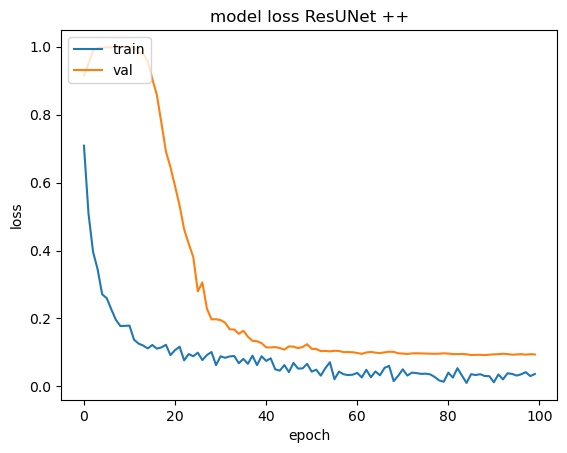

In [9]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss ResUNet ++')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


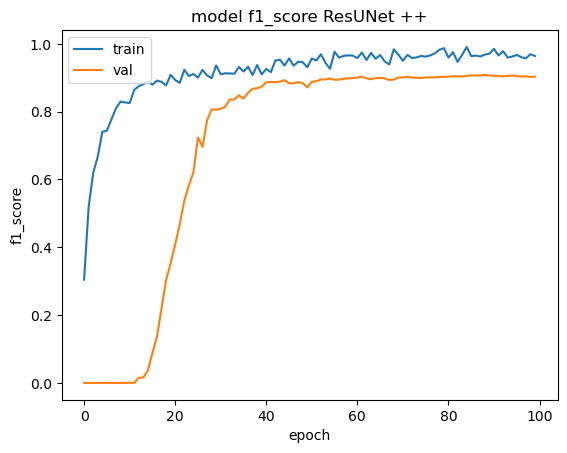

In [10]:
# summarize history for F1

plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1_score ResUNet ++')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


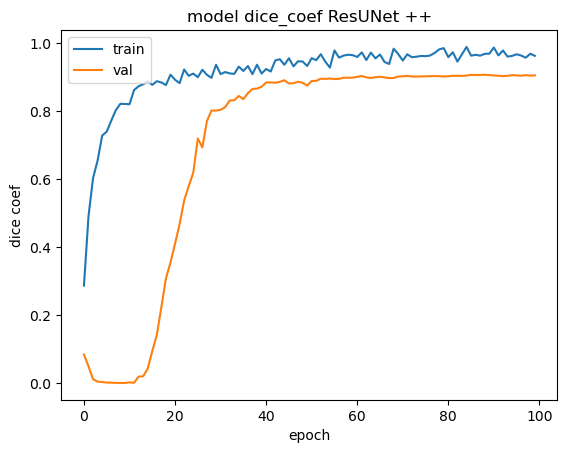

In [11]:
# summarize his.tory for dice_coef

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef ResUNet ++')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256,batch_size=128, shuffle=True)
model = Resunetpp()
model.load_weights(r'C:\TUsimple_ResUNet++\model')

model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = model.evaluate(val_generator,batch_size= 60, verbose=1,)

In [12]:

val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256,batch_size=128, shuffle=False)

X, y = val_generator.__getitem__(0)

predict = model.predict(X)





4/4 [==============================] - 3s 272ms/step


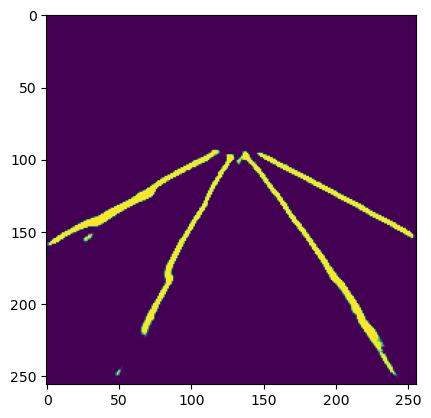

In [13]:
img = predict[2]
plt.imshow(img)

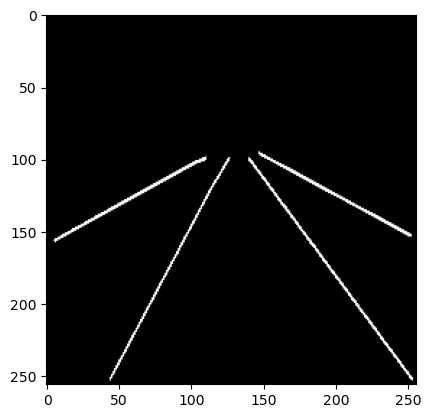

In [14]:
plt.imshow(y[2])

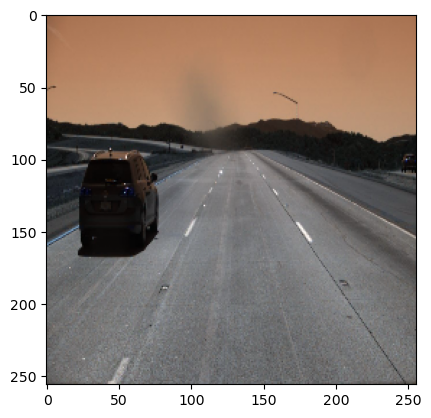

In [15]:
plt.imshow(X[2])